# Eurosat LUC With Pretrained Models

### Config for data paths and terminal colors

In [1]:
class Config:
    DATA_DIR = '../data/euroSat/'
    TRAIN_FILE = DATA_DIR + 'train.csv'
    TEST_FILE = DATA_DIR + 'test.csv'
    SAMPLE_SUBMISSION_FILE = DATA_DIR + 'sample_submission.csv'
    TRAIN_RGB_DIR = DATA_DIR + 'train/EuroSAT_RGB/'
    TRAIN_MS_DIR = DATA_DIR + 'train/EuroSAT_MS/'

    TEST_MS_DIR = DATA_DIR + 'test/NoLabel/'
    MEAN_STD_FILE = "tmp/eurosat_ms_mean_std"
    MEAN_STD_FILE_L2C = "tmp/eurosat_ms_mean_std_L2C"
    MEAN_STD_FILE_L2A = "tmp/eurosat_ms_mean_std_L2A"
    TEST_LABELD_FILE = "tmp/labels.csv"

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

c = bcolors()
config = Config()

### Helper functions for loading pickle data

In [2]:
import pickle

def load_object(fname):
    try:
        with open(fname + ".pickle", "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)


def save_object(obj, fname):
    try:
        with open(fname + ".pickle", "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)

### Defining the Dataset & Datamodule

In [3]:
# import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import cv2

def normalize(image, mean_std):
    mean = mean_std["mean"]
    std = mean_std["std"]
    # mins = mean_std["min"]
    # maxs = mean_std["max"]
    # Reshape mean and std to match broadcasting requirements
    mean = mean[:, np.newaxis, np.newaxis]
    std = std[:, np.newaxis, np.newaxis]

    # Add a small epsilon to avoid division by zero
    epsilon = 1e-7
    image = (image - mean) / (std + epsilon)
    
    # # # min max scaling
    # for chan_i in range(len(image)):
    #     image[chan_i] = (image[chan_i] - mins[chan_i]) / (maxs[chan_i] - mins[chan_i] + 1e-7)
    return image

def histogram_equalize(image):
    for i in range(image.shape[0]):
        image[i] = exposure.equalize_hist(image[i])
    return image

def merge_stack_channels_tensor(image, channel_map):
    batch_size, num_channels, height, width = image.shape
    new_images = []
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    for i in range(batch_size):
        new_image = torch.zeros((3, height * 2, width * 2))
        for row in range(2):
            for col in range(2):
                channels = channel_map[row * 2 + col]
                new_image[:, row * height:(row + 1) * height, col * width:(col + 1) * width] = \
                    image[i, channels, :, :]
        new_images.append(new_image)
    return torch.stack(new_images)

(64, 64, 3)
0.00048828125 1.0


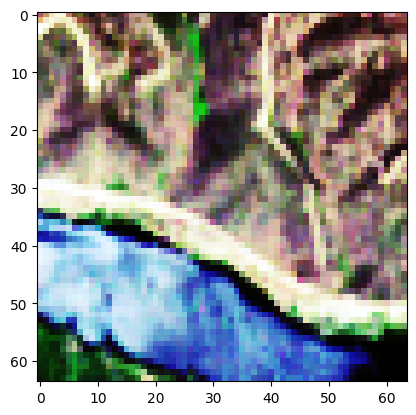

In [4]:
from skimage import exposure
# load a sample image and apply the histogram equalization
import matplotlib.pyplot as plt

im_path = config.DATA_DIR + f"test/NoLabel/test_{4}.npy"
img = np.load(im_path).transpose(2, 0, 1)
img = img[[3, 2, 1]].astype(np.float32)
for i in range(img.shape[0]):
    img[i] = exposure.equalize_hist(img[i])
img = img.transpose(1, 2, 0)
print(img.shape)
print(img.min(), img.max())
plt.imshow(img)
plt.show()

In [5]:
import os
import sys
import time

import numpy as np
import rasterio
import kornia.augmentation as K
from joblib import Parallel, delayed
from torch.utils.data import Dataset
from torchvision import transforms


class EuroSatMS(Dataset):
    def __init__(self,
                 dataframe,
                 root_dir,
                 encoder,
                 select_chan=None,
                 chan_map=None,
                 hist_eq=False,
                 dstype="train",
                 n_jobs=-4):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.select_chan = select_chan
        self.chan_map = chan_map
        self.dstype = dstype
        self.hist_eq = hist_eq

        self.enc = encoder

        print(f"\n{c.OKGREEN}Preloading images...{c.ENDC}")
        print(f"\n{c.OKCYAN}Images:         {len(dataframe)}{c.ENDC}")
        print(f"{c.OKCYAN}Jobs:           {n_jobs} {c.ENDC}\n")

        start_time = time.time()
        result = Parallel(n_jobs=n_jobs)(
            delayed(self.process_image)(idx) for idx in range(len(dataframe))
        )

        self.samples = np.array([x for x, _, _ in result], dtype=np.float32)
        self.targets = np.array([y for _, y, _ in result])
        self.groups = np.array([z for _, _, z in result])
        end_time = time.time()
        t = end_time - start_time
        print(f"\n{c.OKBLUE}Time taken:      {int((t - (t % 60)) / 60)} min {t % 60} sec {c.ENDC}")

    def process_image(self, idx):
        img_path = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])

        if ".npy" in img_path:
            image = np.load(img_path).transpose(2, 0, 1)
        else:
            with rasterio.open(img_path) as src:
                image = np.array(src.read())
                
        if self.dstype == "train":
            target = self.dataframe.iloc[idx, 1]
            target = self.enc.transform(np.array([target]).reshape(-1, 1)).toarray()
            target = target.flatten().astype(np.float32)
        else:
            target = int(self.dataframe.iloc[idx, 0].split("_")[1].split(".")[0])
        
        image = image[self.select_chan].astype(np.float32)
        
        return image, target, idx

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, samp_idx):
        if torch.is_tensor(samp_idx):
            samp_idx = samp_idx.tolist()
        
        image = self.samples[samp_idx]
        
        if self.hist_eq:
            image = histogram_equalize(image)
            
        image = torch.tensor(image, dtype=torch.float32)
        target = torch.tensor(self.targets[samp_idx], dtype=torch.float32)
            
        if self.chan_map:
            image = merge_stack_channels_tensor(image, self.chan_map)
            
        return image, target

In [6]:
from torch.utils.data import DataLoader
import pytorch_lightning as pl


class EuroSatDataLoader(DataLoader):
    LAMBDA_RANGE = (0, 1)
    def __init__(self, ds, batch_size=1, shuffle=False, mixup=True, num_workers=0, tf=None, augment=None):
        super(EuroSatDataLoader, self).__init__(ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        self.transform = tf
        self.augment = augment
        self.mixup = mixup
        
    def mixup_image_batch(self, samp_images, samp_targets):
        _, labels = torch.max(samp_targets, 1)
        mixup = K.RandomMixUpV2(data_keys=["input", "class"], lambda_val=self.LAMBDA_RANGE)

        input_data, mixing_label = mixup(samp_images, labels)
                
        lam_vals = mixing_label[:, 2]
        mix_idx = mixing_label[:, 1].numpy().astype(int)
        org_idx = mixing_label[:, 0].numpy().astype(int)
    
        for i in range(len(samp_targets)):
            samp_targets[i, org_idx[i]] = samp_targets[i, org_idx[i]] - lam_vals[i]
            samp_targets[i, mix_idx[i]] = samp_targets[i, mix_idx[i]] + lam_vals[i]
        
        return input_data, samp_targets

    def __iter__(self):
        for batch_sample in super().__iter__():
            input_data = batch_sample[0]
            class_label = batch_sample[1]
            
            if self.augment:
                input_data = self.augment(input_data)
            
            if self.mixup:
                input_data, class_label = self.mixup_image_batch(input_data, class_label)
            
                
            if self.transform:
                input_data = self.transform(input_data)
            
            yield input_data, class_label
            

class EuroSatDataModule(pl.LightningDataModule):
    def __init__(self, dataset_train, dataset_val, dataset_test, batch_size, num_workers=8, tf_L2C=None, tf_L2A=None, augment=None):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.dataset_train = dataset_train
        self.dataset_val = dataset_val
        self.dataset_test = dataset_test
        
        self.transform_L2C = tf_L2C
        self.transform_L2A = tf_L2A
        self.augment = augment

    def train_dataloader(self):
        return EuroSatDataLoader(self.dataset_train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, tf=self.transform_L2C, augment=self.augment)

    def val_dataloader(self):
        return EuroSatDataLoader(self.dataset_val, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, tf=self.transform_L2A)

    def test_dataloader(self):
        return EuroSatDataLoader(self.dataset_test, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, tf=self.transform_L2C)


## Model Definition
### Function for loading a pretrained model with its transforms

In [7]:
import numpy as np
import pytorch_lightning as pl
import torch
from kornia.constants import Resample
import torchvision.models as tvm
from torchvision import transforms
import kornia.augmentation as K


def get_pretrained_model(model_name, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

    tf_imagenet_v1 = transforms.Compose([
        K.Resize(256, resample=Resample.BILINEAR.BILINEAR),
        K.CenterCrop(224),
        K.Normalize(mean=mean, std=std)
    ])

    tf_imagenet_v2 = transforms.Compose([
        K.Resize(232, resample=Resample.BILINEAR.BILINEAR),
        K.CenterCrop(224),
        K.Normalize(mean=mean, std=std)
    ])

    tf_imagenet_swag = transforms.Compose([
        K.Resize(518, resample=Resample.BICUBIC.BICUBIC),
        K.CenterCrop(518),
        K.Normalize(mean=mean, std=std)
    ])

    if "resnet50" == model_name:
        return tvm.resnet50(weights=tvm.ResNet50_Weights.IMAGENET1K_V2), tf_imagenet_v1
    elif "resnet152" == model_name:
        return tvm.resnet152(weights=tvm.ResNet152_Weights.IMAGENET1K_V2), tf_imagenet_v2
    elif "vit_b_16" == model_name:
        return tvm.vit_b_16(weights=tvm.ViT_B_16_Weights.IMAGENET1K_V1), tf_imagenet_v1
    elif "vit_b_32" == model_name:
        return tvm.vit_b_32(weights=tvm.ViT_B_32_Weights.IMAGENET1K_V1), tf_imagenet_v1
    elif "vit_h_14" == model_name:
        return tvm.vit_h_14(weights=tvm.ViT_H_14_Weights.IMAGENET1K_SWAG_E2E_V1), tf_imagenet_swag
    elif "vgg19" == model_name:
        return tvm.vgg19(weights=tvm.VGG19_Weights.IMAGENET1K_V1), tf_imagenet_v1
    elif "swin_v2_t" == model_name:
        return tvm.swin_v2_t(weights=tvm.Swin_V2_T_Weights.IMAGENET1K_V1), tf_imagenet_v1
    elif "swin_v2_b" == model_name:
        return tvm.swin_v2_b(weights=tvm.Swin_V2_B_Weights.IMAGENET1K_V1), tf_imagenet_v1
    elif "mobilenet_v3_large" == model_name:
        return tvm.mobilenet_v3_large(weights=tvm.MobileNet_V3_Large_Weights.IMAGENET1K_V2), tf_imagenet_v2
    elif "googlenet" == model_name:
        return tvm.googlenet(weights=tvm.GoogLeNet_Weights.IMAGENET1K_V1), tf_imagenet_v1
    elif "efficientnet_v2_m" == model_name:
        return tvm.efficientnet_v2_m(weights=tvm.EfficientNet_V2_M_Weights.IMAGENET1K_V1), tf_imagenet_v1
    elif "efficientnet_v2_s" == model_name:
        return tvm.efficientnet_v2_s(weights=tvm.EfficientNet_V2_S_Weights.IMAGENET1K_V1), tf_imagenet_v1

MODEL_NAME_LIST = [
    "resnet50",
    "resnet152",
    "vit_b_16",
    "vit_h_14",
    "vit_b_32",
    "vgg19",
    "swin_v2_t",
    "swin_v2_b",
    "mobilenet_v3_large",
    "googlenet",
    "efficientnet_v2_m"
]

# for i in MODEL_NAME_LIST:
#     model, _ = get_pretrained_model(i)
#     print(model.__class__.__name__)
#     print(model)

### Pytorch Lightning Model Class

In [8]:
import numpy as np
import pytorch_lightning as pl
import torch
from tabulate import tabulate
from torch import optim, nn
from torch.optim.lr_scheduler import ExponentialLR

class EuroSatPreTrainedModel(pl.LightningModule):
    def __init__(self,
                 backbone,
                 dropout,
                 layers,
                 learning_rate,
                 weight_decay,
                 opt="adam",
                 momentum=0.9,
                 gamma=0.9,
                 target_smooth=0,
                 n_classes=10):
        super(EuroSatPreTrainedModel, self).__init__()

        self.backbone = backbone
        self.weight_decay = weight_decay
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.gamma = gamma
        self.opt = opt

        self.criterion = nn.CrossEntropyLoss(
            label_smoothing=target_smooth
        )

        self.accuracy = [0, 0]
        self.train_losses = []
        self.val_losses = []
        self.ep_out = [[], []]
        self.ep_true = [[], []]
        self.num_features = 0
        backbone_class_name = self.backbone.__class__.__name__
        if backbone_class_name == "VisionTransformer":
            self.num_features = self.backbone.heads[0].in_features
            self.backbone.heads = nn.Identity()
        elif backbone_class_name == "SwinTransformer":
            self.num_features = self.backbone.head.in_features
            self.backbone.head = nn.Identity()
        elif backbone_class_name in ["VGG", "MobileNetV3", "EfficientNet"]:
            self.num_features = self.backbone.classifier[-1].in_features
            self.backbone.classifier = nn.Identity()
        elif backbone_class_name in ["GoogLeNet", "ResNet"]:
            self.num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        else:
            raise ValueError(f"Backbone <{backbone_class_name}> is not valid for the EuroSatPreTrainedModel")
        
        print(f"Num features: {self.num_features}")
        
        # Cunstruct the classifier
        self.classifier = nn.Sequential()
        if len(layers) > 0:
            for i, layer in enumerate(layers):
                self.classifier.add_module(f"fc_{i}", nn.Linear(self.num_features, layer))
                self.classifier.add_module(f"relu_{i}", nn.ReLU())
                self.classifier.add_module(f"dropout_{i}", nn.Dropout(p=dropout))
                self.num_features = layer
            self.classifier.add_module(f"fc_out", nn.Linear(self.num_features, n_classes))
        else:
            self.classifier.add_module(f"dropout", nn.Dropout(p=dropout))
            self.classifier.add_module(f"fc_out", nn.Linear(self.num_features, n_classes))

        # Freeze the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Unfreeze the classifier
        for param in self.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

    def training_step(self, batch_sample, batch_idx):
        sample_inputs, sample_labels = batch_sample
        sample_outputs = self(sample_inputs)
        _, labels = torch.max(sample_labels, 1)
        _, predicted = torch.max(sample_outputs, 1)

        self.ep_out[0].append(predicted.cpu().numpy())
        self.ep_true[0].append(labels.cpu().numpy())

        loss = self.criterion(sample_outputs, labels)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        _, labels = torch.max(labels, 1)
        _, predicted = torch.max(outputs, 1)
        self.ep_out[1].append(predicted.cpu().numpy())
        self.ep_true[1].append(labels.cpu().numpy())
        loss = self.criterion(outputs, labels)
        self.val_losses.append(loss.item())
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)

    def on_validation_epoch_end(self):
        all_preds = np.concatenate(self.ep_out[1])
        all_true = np.concatenate(self.ep_true[1])
        correct = np.sum(all_preds == all_true)
        self.accuracy[1] = correct / len(all_true)
        self.log('val_acc', self.accuracy[1], prog_bar=True, on_step=False, on_epoch=True)

        if len(self.ep_out[0]) > 0:
            all_preds = np.concatenate(self.ep_out[0])
            all_true = np.concatenate(self.ep_true[0])
            correct = np.sum(all_preds == all_true)
            self.accuracy[0] = correct / len(all_true)
            self.log('train_acc', self.accuracy[0], prog_bar=True, on_step=False, on_epoch=True)
            acc_div = self.accuracy[0] - self.accuracy[1]
            self.log('acc_div', acc_div, prog_bar=False, on_step=False, on_epoch=True)

        loss_div =  np.abs(np.mean(self.train_losses) - np.mean(self.val_losses))
        self.log('loss_div', loss_div, prog_bar=False, on_step=False, on_epoch=True)

        self.ep_out = [[], []]
        self.ep_true = [[], []]

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)

        _, labels = torch.max(labels, 1)
        _, predicted = torch.max(outputs, 1)

        loss = self.criterion(outputs, labels)

        self.ep_out.append(predicted.cpu().numpy())
        self.ep_true.append(labels.cpu().numpy())

        self.log('test_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_acc', self.accuracy, prog_bar=True, on_step=True, on_epoch=True)

    def on_test_epoch_end(self):
        all_preds = np.concatenate(self.ep_out)
        all_true = np.concatenate(self.ep_true)
        correct = np.sum(all_preds == all_true)
        self.accuracy = correct / len(all_true)
        self.log('test_accuracy', self.accuracy, prog_bar=True, on_step=False, on_epoch=True)

    def on_test_epoch_start(self) -> None:
        self.ep_out = []
        self.ep_true = []

    def configure_optimizers(self):
        if self.opt == "sgd":
            optimizer = optim.SGD(
                params=filter(lambda p: p.requires_grad, self.parameters()),
                lr=self.learning_rate,
                weight_decay=self.weight_decay,
                momentum=self.momentum
            )
        else:
            optimizer = optim.AdamW(
                params=filter(lambda p: p.requires_grad, self.parameters()),
                lr=self.learning_rate,
                weight_decay=self.weight_decay
            )
        scheduler = ExponentialLR(optimizer, gamma=self.gamma)
        return [optimizer], [scheduler]

    def unfreeze_layers(self, n):
        if n == 0:
            return

        n_params = [(name, param) for name, param in self.backbone.named_parameters()]
        n_params = n_params[::-1]

        total_params = sum(param.numel() for name, param in n_params)
        params_to_unfreeze = int(n * total_params)
        unfrozen_params_count = 0
        for name, param in n_params:
            print(f"Unfreezing: {name}")
            param.requires_grad = True
            unfrozen_params_count += param.numel()
            if unfrozen_params_count >= params_to_unfreeze:
                break

# Loading The Dataset
## Setting parameters

- **PRETRAINED_MODEL**: Name of the model to use.
- **CHANNELS_2C**: Channels to select for L2C data.
- **CHANNELS_2A**: Channels to use for L2A data.
- **NUM_CLASSES**: Number of classes to predict.

In [9]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

print(MODEL_NAME_LIST)
PRETRAINED_MODEL = "resnet50"

model, _ = get_pretrained_model(PRETRAINED_MODEL)
print(model)

CHANNELS_2C = [3, 2, 1]
CHANNELS_2A = [3, 2, 1]
CHANNEL_MAP = [
    [3, 2, 1],
    [6, 5, 4],
    [9, 8, 7],
    [10, 11, 0]
]
NUM_CLASSES = 10
TEST_SPLIT = 0.05

['resnet50', 'resnet152', 'vit_b_16', 'vit_h_14', 'vit_b_32', 'vgg19', 'swin_v2_t', 'swin_v2_b', 'mobilenet_v3_large', 'googlenet', 'efficientnet_v2_m']
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

## Load metadata description, encode labels and get transforms for model

In [10]:
df = pd.read_csv(config.TRAIN_FILE)
df_test = pd.read_csv(config.TEST_LABELD_FILE)

encoder = OneHotEncoder()
encoder = encoder.fit(df[['label']].values.reshape(-1, 1))
save_object(encoder, config.DATA_DIR + "on_hot_encoder")

## Loading the normalisation parameters (mean, std)

In [11]:
import tabulate

tabel_data_1 = []
tabel_data_2 = []

obj_L2C = load_object(config.MEAN_STD_FILE_L2C)
obj_L2A = load_object(config.MEAN_STD_FILE_L2A)

for i in range(len(obj_L2C['mean'])):
    tabel_data_1.append([
        f"{c.OKCYAN}{obj_L2C['mean'][i]:.4f}{c.ENDC}", 
        f"{c.OKBLUE}{obj_L2A['mean'][i]:.4f}{c.ENDC}", 
        f"{c.OKCYAN}{obj_L2C['std'][i]:.4f}{c.ENDC}", 
        f"{c.OKBLUE}{obj_L2A['std'][i]:.4f}{c.ENDC}"
    ])
    tabel_data_2.append([
        f"{c.OKCYAN}{obj_L2C['min'][i]:.4f}{c.ENDC}", 
        f"{c.OKBLUE}{obj_L2A['min'][i]:.4f}{c.ENDC}", 
        f"{c.OKCYAN}{obj_L2C['max'][i]:.4f}{c.ENDC}", 
        f"{c.OKBLUE}{obj_L2A['max'][i]:.4f}{c.ENDC}"
    ])

print(tabulate.tabulate(tabel_data_1, headers=[f"{c.OKCYAN}L2C Mean{c.ENDC}", f"{c.OKBLUE}L2A Mean{c.ENDC}", f"{c.OKCYAN}L2C Std{c.ENDC}", f"{c.OKBLUE}L2A Std{c.ENDC}"]))
print()
print(tabulate.tabulate(tabel_data_2, headers=[f"{c.OKCYAN}L2C Min{c.ENDC}", f"{c.OKBLUE}L2A Min{c.ENDC}", f"{c.OKCYAN}L2C Max{c.ENDC}", f"{c.OKBLUE}L2A Max{c.ENDC}"]))

_, transforms_L2C = get_pretrained_model(PRETRAINED_MODEL, mean=obj_L2C['mean'][CHANNELS_2A], std=obj_L2C['std'][CHANNELS_2A])
_, transforms_L2A = get_pretrained_model(PRETRAINED_MODEL, mean=obj_L2A['mean'][CHANNELS_2A], std=obj_L2A['std'][CHANNELS_2A])

norm_par_2C = dict(
    mean=obj_L2C['mean'][CHANNELS_2A],
    std=obj_L2C['std'][CHANNELS_2A],
    min=obj_L2C['min'][CHANNELS_2A],
    max=obj_L2C['max'][CHANNELS_2A]
)

norm_par_2A = dict(
    mean=obj_L2A['mean'][CHANNELS_2A],
    std=obj_L2A['std'][CHANNELS_2A],
    min=obj_L2A['min'][CHANNELS_2A],
    max=obj_L2A['max'][CHANNELS_2A]
)

  L2C Mean    L2A Mean    L2C Std    L2A Std
----------  ----------  ---------  ---------
  1353.73      380.173    65.2889    115.16
  1117.2       400.149   153.755     209.123
  1041.89      628.864   187.676     241.177
   946.556     578.871   278.091     301.069
  1199.19      943.427   227.896     269.481
  2003        1826.24    355.89      420.199
  2374.01     2116.67    455.075     503.757
  2301.23     2205.98    530.717     597.968
   732.185    2281.18     98.9179    529.349
  1820.7      2266.93    378.115     403.888
  1118.2      1487.69    303.068     398.094
  2599.78      959.235   502.103     342.399

  L2C Min    L2A Min    L2C Max    L2A Max
---------  ---------  ---------  ---------
 1236.94     198.793   1560.36     795.486
  864.673    100.154   2144.7     1908.95
  690.741    210.173   2197.04    2160.55
  470.055    143.857   2442.57    2265.38
  742.607    425.231   2066.73    2041.95
 1215.66     846.068   3120.73    3159.71
 1388.28     961.567   3759.04 

## Initialize the dataset for train, test and validation

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=TEST_SPLIT, stratify=df['label'])

ds_train = EuroSatMS(
    train_df,
    config.TRAIN_MS_DIR,
    encoder=encoder,
    select_chan=CHANNELS_2C,
    hist_eq=True,
    # chan_map=CHANNEL_MAP,
    # norm_param=norm_par_2C
)

ds_val = EuroSatMS(
    df_test,
    config.TEST_MS_DIR,
    encoder=encoder,
    select_chan=CHANNELS_2A,
    hist_eq=True,
    # chan_map=CHANNEL_MAP,
    # norm_param=norm_par_2A
)

ds_test = EuroSatMS(
    val_df,
    config.TRAIN_MS_DIR,
    encoder=encoder,
    select_chan=CHANNELS_2C,
    hist_eq=True,
    # chan_map=CHANNEL_MAP,
    # norm_param=norm_par_2C
)

print(f"""\n{c.OKGREEN}Train dataset:      {len(ds_train)} samples{c.ENDC}""")
print(f"""{c.OKGREEN}Validation dataset: {len(ds_val)} samples{c.ENDC}""")
print(f"""{c.OKGREEN}Test dataset:       {len(ds_test)} samples{c.ENDC}""")


Preloading images...

Images:         25650
Jobs:           -4 



# Model Training


In [ ]:
from datetime import datetime
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import wandb
import torch
from tabulate import tabulate

CKPT_PATH = f'checkpoints/{PRETRAINED_MODEL}/'

## Define data augmentations

In [ ]:
from kornia.constants import Resample
import kornia.augmentation as K
from torch import nn

p1, p2, p3 = 0.6, 0.6, 0.3
augmentation = nn.Sequential(
    K.RandomHorizontalFlip(p=p1),
    K.RandomVerticalFlip(p=p1),
    K.RandomAffine(
        degrees=30,
        translate=None,
        scale=(0.9, 1.3),
        shear=20,
        resample="nearest",
        padding_mode=2,
        p=p1),
    K.RandomBrightness((0.7, 1.3), p=p2),
    K.RandomContrast((0.7, 1.3), p=p2),
    K.RandomSaturation((0.7, 1.3), p=p2),
    # K.RandomBoxBlur((2, 2), p=p2),
    # K.RandomRGBShift(0.1, 0.1, 0.1, p=p2),
    # K.RandomSaltAndPepperNoise(amount=(0.001, 0.01), salt_vs_pepper=(0.4, 0.6), p=p2),
    # K.RandomPlasmaContrast(roughness=(0.1, 0.71), p=p3),
    K.CenterCrop(size=(64, 64)),
)

In [ ]:
import matplotlib.pyplot as plt

chan = [3, 2, 1]

_, transforms_L2C = get_pretrained_model(PRETRAINED_MODEL) #, mean=obj_L2C['mean'][CHANNELS_2A], std=obj_L2C['std'][CHANNELS_2A])
dl_train = EuroSatDataLoader(ds_train, batch_size=16, shuffle=True, tf=transforms_L2C, augment=augmentation, mixup=True)

for im_b, tar_b in dl_train:
    im_batch = im_b
    tar_batch = tar_b
    break


fig, axs = plt.subplots(2, 8, figsize=(20, 10))
axs = axs.flatten()
for i, ax in enumerate(axs):
    # im_path = config.DATA_DIR + f"test/NoLabel/test_{4}.npy"
    # img = np.load(im_path).transpose(2, 0, 1)
    # img = img[chan].astype(np.float32)
    
    img = im_batch[i].numpy()

    # for channel in range(len(chan)):
    #     rgb_min, rgb_max = img[channel].min(), img[channel].max()
    #     img[channel] = (img[channel] - rgb_min) / (rgb_max - rgb_min)
    # 
    # img = torch.tensor(img, dtype=torch.float32)
    # 
    # img = augmentation(img)
    # img = transform(img)
    # 
    # img = img.squeeze(0).numpy()
    # undo the normalization
    # for can in range(len(chan)):
    #     img[can] = img[can] * obj_L2C['std'][chan[can]] + obj_L2C['mean'][chan[can]]
    rgb_min, rgb_max = img.min(), img.max()
    img = (img - rgb_min) / (rgb_max - rgb_min + 1e-7)
    img = img.clip(0, 1)
    ax.imshow(img.transpose(1, 2, 0))
    ax.axis('off')
plt.tight_layout()
plt.show()


## Initialize the LightningDataModule and LightningModule

In [ ]:
BATCH_SIZE = 32
UNFREEZE_P = [0, 0.2, 0.5, 1]
EP_UNFREEZE = [3, 3, 3, 3]

model, _ = get_pretrained_model(PRETRAINED_MODEL)
print(model)

LR = [0.0003, 0.0001, 0.0001]
LAYERS = []
OPTIMIZER = "adam"
TARGET_SMOOTH = 0.1
WEIGHT_DECAY = 0.001
DROPOUT = [0, 0, 0]
GAMMA = 0.9
MOMENTUM = 0.9


In [ ]:
obj_L2C = load_object(config.MEAN_STD_FILE_L2C)
obj_L2A = load_object(config.MEAN_STD_FILE_L2A)

_, transforms_L2C = get_pretrained_model(PRETRAINED_MODEL) #, mean=obj_L2C['mean'][CHANNELS_2A], std=obj_L2C['std'][CHANNELS_2A])
_, transforms_L2A = get_pretrained_model(PRETRAINED_MODEL) #, mean=obj_L2A['mean'][CHANNELS_2A], std=obj_L2A['std'][CHANNELS_2A])

data_module = EuroSatDataModule(ds_train, ds_val, ds_test, BATCH_SIZE, num_workers=8, tf_L2C=transforms_L2C, tf_L2A=transforms_L2A, augment=augmentation)

In [ ]:
logger = WandbLogger(
    project="eurosat_" + PRETRAINED_MODEL.split("_")[0],
    name=PRETRAINED_MODEL,
    log_model=False,
)

checkpoint_callback = ModelCheckpoint(
    dirpath=CKPT_PATH + datetime.now().strftime("%H-%M"),
    filename='{epoch:02d}-{train_loss_epoch:.2f}-{val_loss:.2f}-{train_acc:.2f}-{val_acc:.2f}',
    save_top_k=2,
    mode="max",
    monitor="val_acc",
    verbose=False
)

early_stopping_1 = EarlyStopping(
    monitor="val_acc",
    patience=4, mode="max"
)

early_stopping_2 = EarlyStopping(
    monitor="acc_div",
    patience=20, mode="max",
    stopping_threshold=0.3
)

for i in range(len(UNFREEZE_P)):
    model, _ = get_pretrained_model(PRETRAINED_MODEL)

    model_params = dict(
        backbone=model,
        learning_rate=LR[i],
        layers=LAYERS,
        opt=OPTIMIZER,
        gamma=GAMMA,
        momentum=MOMENTUM,
        target_smooth=TARGET_SMOOTH,
        dropout=DROPOUT[i],
        weight_decay=WEIGHT_DECAY,
    )

    if i > 0:
        model_train = EuroSatPreTrainedModel.load_from_checkpoint(
            checkpoint_callback.best_model_path,
            **model_params
        )
    else:
        model_train = EuroSatPreTrainedModel(
            **model_params
        )

    trainer = Trainer(
        max_epochs=EP_UNFREEZE[i],
        accelerator="auto",
        devices=1,
        logger=logger,
        callbacks=[checkpoint_callback, early_stopping_1, early_stopping_2],
    )
    model_train.unfreeze_layers(float(UNFREEZE_P[i]))
    trainer.fit(model_train, datamodule=data_module)

In [ ]:
# After training loop finishes, get logged metrics from wandb
api = wandb.Api()
runs = api.runs(f"{logger.entity}/{logger.project}", {"config.project": logger.name})

# Initialize an empty list to store metrics
metrics_list = []

# Iterate over runs and extract metrics
for run in runs:
    run_metrics = run.history(keys=['train_loss_epoch', 'val_loss', 'train_acc', 'val_acc', 'acc_div'])
    metrics_list.append(run_metrics)

# Concatenate metrics into a single DataFrame
metrics_df = pd.concat([pd.DataFrame(metrics) for metrics in metrics_list], ignore_index=True)

# Display or further process the DataFrame as needed
print(metrics_df)

In [ ]:
p, l, i = [], [], []
for f in os.listdir(config.TEST_MS_DIR):
    p.append(f)
    l.append("AnnualCrop")
    i.append(int(f.split('_')[1].split('.')[0]))

i, p, l = zip(* sorted(zip(i, p, l)))
data_sub = np.array([p, l]).transpose()
sub_df = pd.DataFrame(data_sub, columns=["path", "label"])

In [ ]:
data_sub = []
for f in os.listdir(config.TEST_MS_DIR):
    data_sub.append([f, "AnnualCrop"])

sub_df = pd.DataFrame(data_sub, columns=["path", "label"])
_, transform = get_pretrained_model(PRETRAINED_MODEL)
encoder = load_object(config.DATA_DIR + "on_hot_encoder")
dataset_sub = EuroSatMS(
    sub_df,
    config.TEST_MS_DIR,
    encoder=encoder,
    select_chan=CHANNELS_2A,
    transform=None,
    # norm_param=norm_par_2A,
    dstype="test"
)

dataset = torch.utils.data.Dataset()
dataloader = EuroSatDataLoader(dataset_sub, batch_size=32, shuffle=True, num_workers=8, tf=transforms_L2A)

In [ ]:
import torch
import numpy as np

model, _ = get_pretrained_model(PRETRAINED_MODEL)
model_eval = EuroSatPreTrainedModel.load_from_checkpoint(
    "checkpoints/resnet50/13-02/epoch=00-val_loss=1.66-val_acc=0.62.ckpt", #checkpoint_callback.best_model_path,
    backbone=model,
    learning_rate=0.001,
    layers=[],
    opt="adam",
    gamma=0.9,
    momentum=0.9,
    target_smooth=0.3,
    dropout=0.3,
    weight_decay=0.001,
)
print(checkpoint_callback.best_model_path)

device = "cuda"
model_eval = model_eval.to(device)
model_eval.eval()

N_CLASSES = 10
categorys = encoder.categories_[0]
print(categorys)

In [ ]:
predictions = []
probabilities = []
ohe = []
images = []
sample_ids = []

    
with torch.no_grad():
    for batch_samp in dataloader:
        inputs, samp_id = batch_samp
        inputs = inputs.to(device)
            
        outputs = model_eval(inputs)
        _, preds = torch.max(outputs, 1)
        
        preds = np.array(preds.cpu().numpy())
        
        pred_labels = np.array([categorys[p] for p in preds])
        
        predictions.extend(pred_labels)
        images.extend(inputs.cpu())
        sample_ids.extend(samp_id.cpu().numpy())

In [ ]:
import pandas as pd

sample_ids = [int(s) for s in sample_ids]

submission_df = pd.DataFrame({'test_id': np.array(sample_ids), 'label': np.array(predictions)})
submission_df = submission_df.sort_values(by='test_id')
print(submission_df.head())

submission_df.to_csv('submission.csv', index=False)
print(np.unique(predictions, return_counts=True))

In [ ]:
import torch
import random
from matplotlib import pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
samp_batch_idx = [i for i in range(0, len(sample_ids))]
random.shuffle(samp_batch_idx)
samp_batch_idx = np.array(samp_batch_idx)
n = 5

for param in model_eval.backbone.parameters():
    param.requires_grad = True


for batch_start in range(0, n*8, 8):  # Iterate in steps of 8
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Create a new figure for each batch
    axs = axs.flatten()  # Flatten the grid for easy iteration

    for idx, ax in zip(samp_batch_idx[batch_start:batch_start+8], axs):
        pred = predictions[idx]
        samp_id = sample_ids[idx]
        im_path = config.DATA_DIR + f"test/NoLabel/test_{samp_id}.npy"
        # img = images[idx].unsqueeze(0).requires_grad_(True).to(device)
        img = np.load(im_path).transpose(2, 0, 1)
        img = img[[3, 2, 1]].astype(np.float32)
        
        rgb_min, rgb_max = img.min(), img.max()
        img = (img - rgb_min) / (rgb_max - rgb_min)
        img = img.clip(0, 1)
        ax.imshow(img.transpose(1, 2, 0))
        ax.set_title(pred, fontsize=20)
        ax.axis('off')
        

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

# Hyperparameter Tuning

In [ ]:
HP_RESULTS_PATH = "hp_results/hp_results.csv"

hp_results = pd.DataFrame(
    columns=[
        "model", "batch_size", "lr", "wd", "layers", "optimizer",
        "train_loss_1", "train_loss_2", "val_loss_1", "val_loss_2",
        "val_acc_1", "val_acc_2", "num_freez", "ep_val_acc", "epochs"
        ]
    )

c_i = 0
while os.path.isfile(HP_RESULTS_PATH):
    HP_RESULTS_PATH = f"hp_results/hp_results_{c_i}.csv"
    c_i+=1

hp_results.to_csv(HP_RESULTS_PATH, index=False)

In [ ]:
import pandas as pd
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger


# Fix parameters
GAMMA = 0.9
MOMENTUM = 0.9
DROPOUT = 0.4

# Function to perform a single hyperparameter tuning run
def train_eurosat(config):
    model, _ = get_pretrained_model(config["model"])

    data_module = EuroSatDataModule(ds_train, ds_val, ds_test, config["batch_size"])

    model_train = EuroSatPreTrainedModel(
        backbone=model,
        learning_rate=config["lr"],
        layers=config["head_layers"],
        opt=config["optimizer"],
        gamma=GAMMA,
        momentum=MOMENTUM,
        dropout=DROPOUT,
        weight_decay=config["weight_decay"],
    )
    run_name = str(config["model"])
    run_id = str(hash(run_name + str(config)))
    logger = CSVLogger(save_dir='logs/', name=run_name, version=run_id)

    checkpoint_callback = ModelCheckpoint(
        dirpath=CKPT_PATH + datetime.now().strftime("%H-%M"),
        filename='{epoch:02d}-{val_loss:.2f}-{train_loss_epoch:.2f}',
        save_top_k=1,
        monitor="val_loss",
        verbose=False
    )

    early_stopping = EarlyStopping(
        monitor="val_train_div",
        patience=20, mode="max",
        stopping_threshold=0.3
    )

    trainer = Trainer(
        max_epochs=config["ep_freez"],
        accelerator="auto",
        devices=1,
        logger=logger,
        callbacks=[checkpoint_callback, early_stopping],
    )
    print(float(config["unfreez_layers_p"] / 2))
    model_train.unfreeze_layers(float(config["unfreez_layers_p"] / 2))
    trainer.fit(model_train, datamodule=data_module)

    val_acc_1 = trainer.callback_metrics.get("val_acc").item()
    val_loss_1 = trainer.callback_metrics.get("val_loss").item()
    ep_loss_1 = trainer.callback_metrics.get("train_loss_epoch").item()

    model_train.unfreeze_layers(config["unfreez_layers_p"])

    trainer = Trainer(
        max_epochs=config["ep_unfreez"],
        accelerator="auto",
        devices=1,
        logger=logger,
        callbacks=[checkpoint_callback, early_stopping],
    )

    # Second phase of training, continuing from the last state
    trainer.fit(model_train, datamodule=data_module)

    ep_loss_2 = trainer.callback_metrics.get("train_loss_epoch").item()
    val_acc_2 = trainer.callback_metrics.get("val_acc").item()
    val_loss_2 = trainer.callback_metrics.get("val_loss").item()

    metrics_df = pd.read_csv(f'logs/{run_name}/{run_id}/metrics.csv')
    ep_val_acc = metrics_df[['epoch', 'val_acc']].dropna()
    val_acc = ep_val_acc[['val_acc']].values
    epochs = ep_val_acc[['epoch']].values

    hp_results = pd.read_csv(HP_RESULTS_PATH)

    hp_results.loc[len(hp_results) + 1] = [
        config["model"], config["batch_size"], config["lr"], config["weight_decay"],
        config["head_layers"], config["optimizer"], ep_loss_1, ep_loss_2, val_loss_1,
        val_loss_2, val_acc_1, val_acc_2, config["unfreez_layers_p"], val_acc, epochs]
    print(hp_results.loc[len(hp_results)])
    hp_results.to_csv(HP_RESULTS_PATH, index=False)




In [ ]:
from itertools import product

hp_param_grid = {
    "model": [
        "resnet50_RGB",
        "vit_b_16",
        # "vgg19",
        "swin_v2_t",
        # "mobilenet_v3_small",
        # "googlenet",
        # "efficientnet_v2_s"
    ],
    "ep_freez": [10],
    "ep_unfreez": [5],
    "unfreez_layers_p": [0.3, 0.5, 0.7],
    "batch_size": [32, 64, 256],
    "lr": [0.0005, 0.00025, 0.0001, 0.000075, 0.00005, 0.000025],
    "head_layers": [[]],
    "optimizer": ["adam"],
    "weight_decay": [0.01, 0.005, 0.001, 0.0005, 0.0001]
}

combinations = product(*hp_param_grid.values())

# Create a list to store the hyperparameter dictionaries
hyperparameter_configs = []

# Loop through each combination and create a dictionary
for combination in combinations:
    hyperparameter_config = {}
    for param_name, param_value in zip(hp_param_grid.keys(), combination):
        hyperparameter_config[param_name] = param_value
    hyperparameter_configs.append(hyperparameter_config)

print("Total Iterations: ", len(hyperparameter_configs))

In [ ]:
import random

seed_everything(36)

random.shuffle(hyperparameter_configs)

for i in range(len(hyperparameter_configs)):
    print("Itteration: ", i)
    print(hyperparameter_configs[i])
    train_eurosat(hyperparameter_configs[i])

In [ ]:
torch.cuda.empty_cache()

# Analyze Results

In [ ]:
import pandas as pd

HP_RESULTS_PATH = "/content/drive/MyDrive/EuroSat_LUC/hp_results_1.csv"

cols = ['model', 'batch_size', 'lr', 'wd', 'optimizer', 'val_acc_1', 'val_acc_2']
df = pd.read_csv(HP_RESULTS_PATH)
print(df.columns)

df = df.sort_values(by=["val_acc_1"], ascending=False)
print(df.head(10))